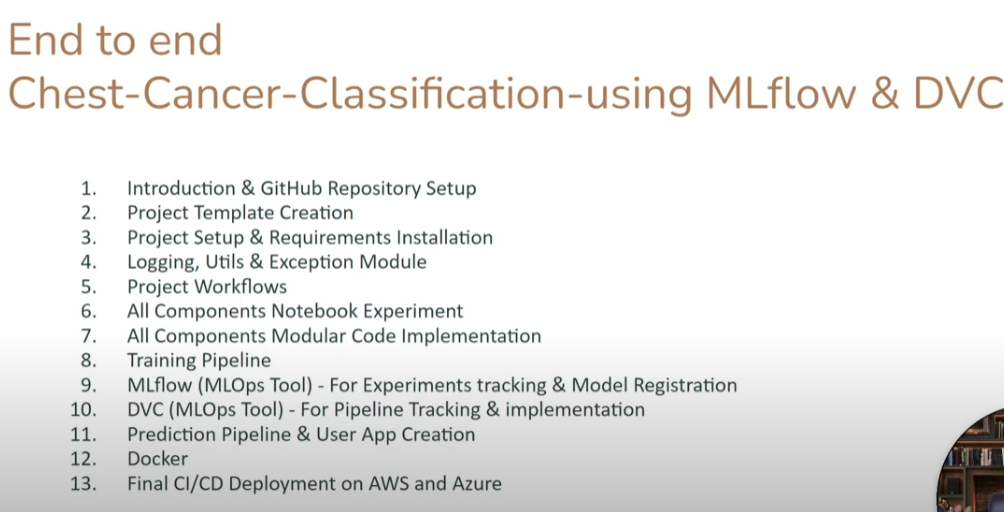

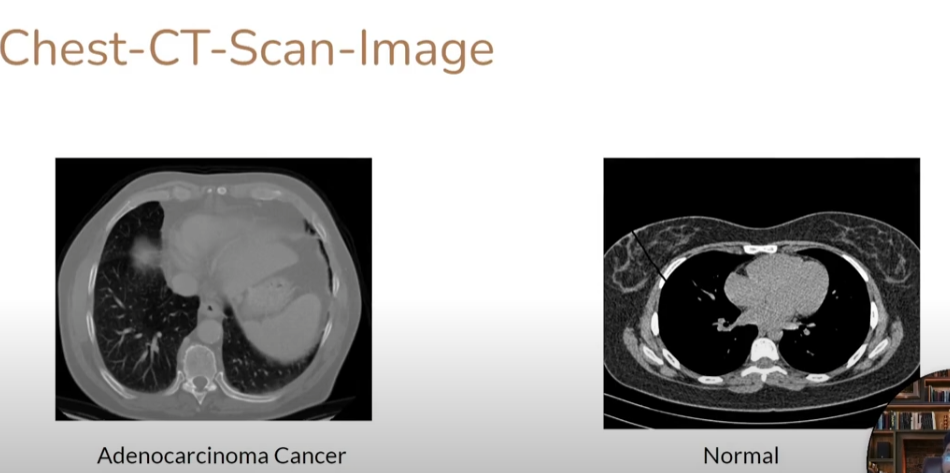

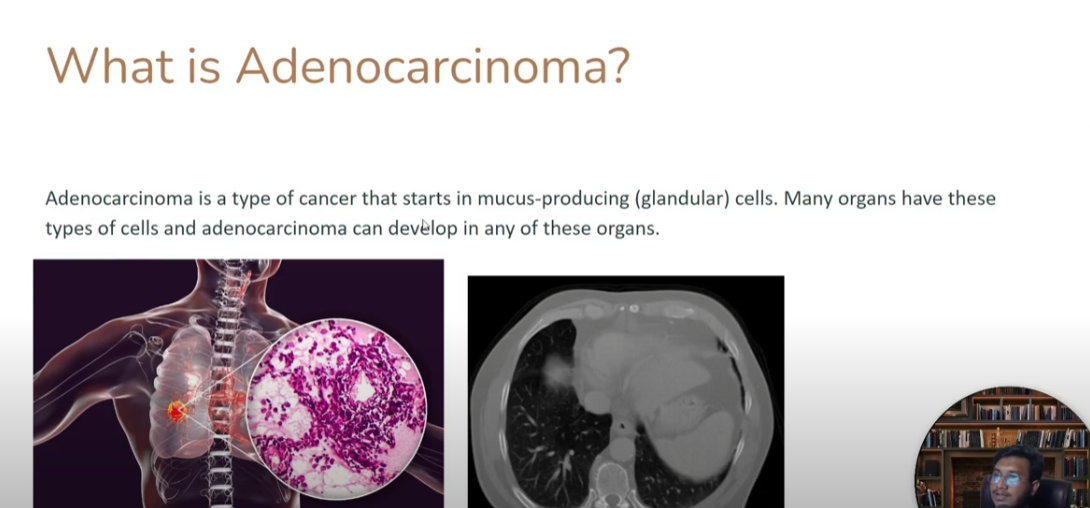

### MLFlow

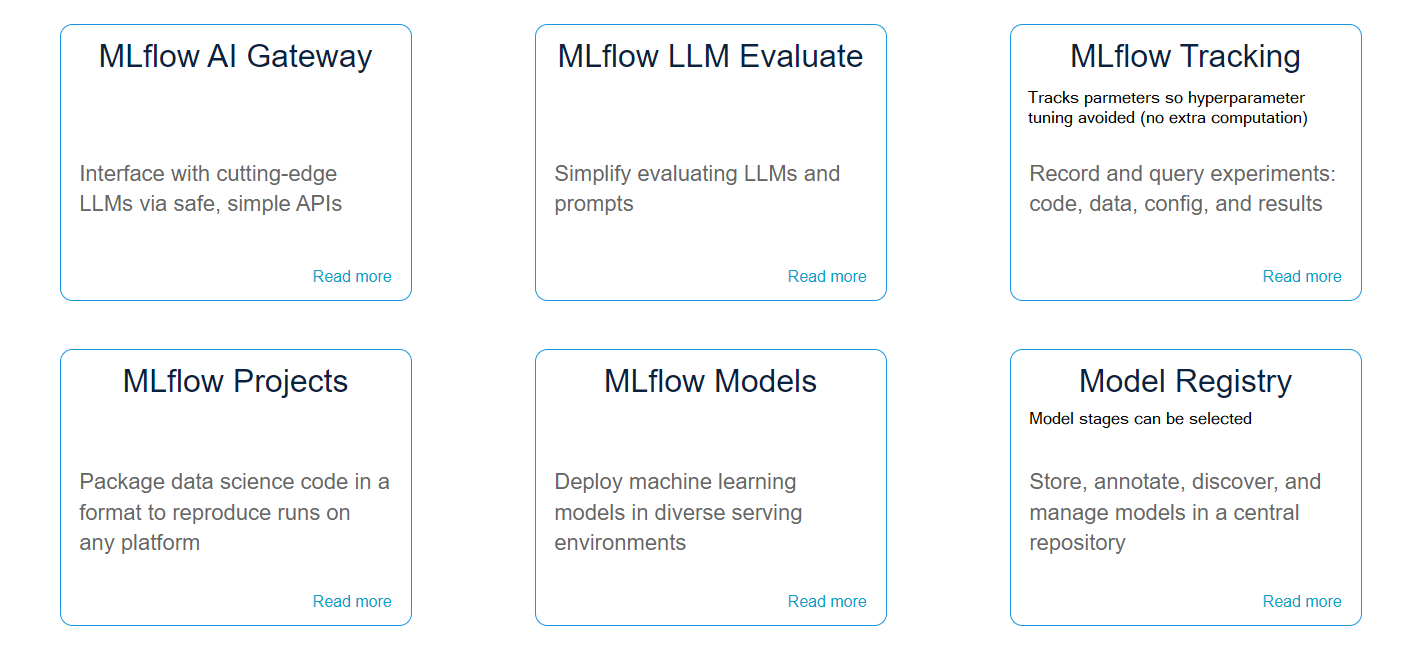

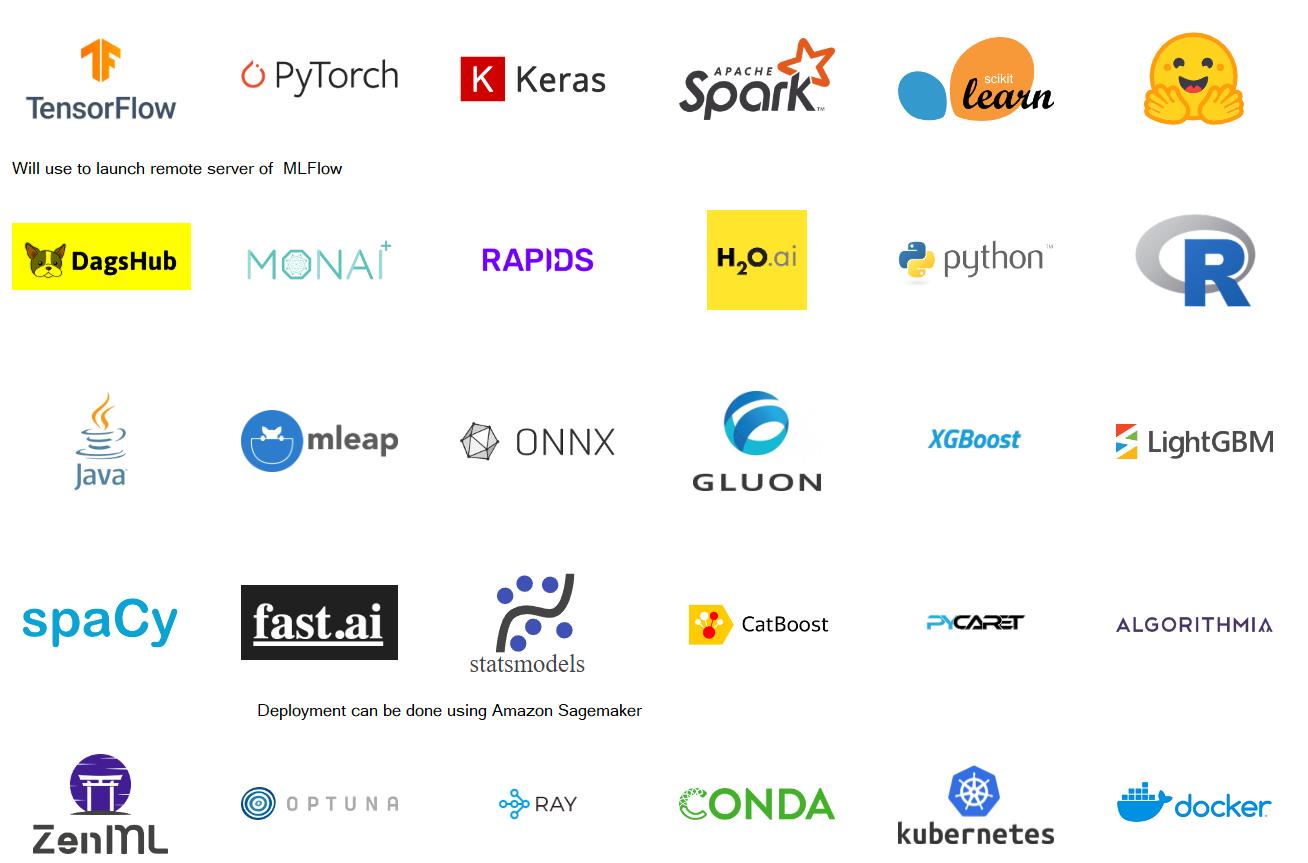

### MLFlow Tracking - automate paramter tuning to get best model

*(Better than Hyperparameter tuning)*

Say regression problem -> wine quality

Algo -> ElasticNet -> alpha, l1_ratio (params) -> Loss (r2, MSE, MAE)

Create csv file and add these results manually

Experiment1: alpha=0.1, l1_ratio=0.5 get Losses say loss1 :: say you don't like results

Experiment2: alpha=0.2, l1_ratio=0.7 get Losses say loss2

Experiment3: ... go on

can automate this tracking using MLFlow Experiment and see graphs, ui, best model/params, etc. and can also do model registry as well

MLflow Training Tutorial
This train.pynb Jupyter notebook predicts the quality of wine using sklearn.linear_model.ElasticNet.

This is the Jupyter notebook version of the train.py example 

In [ ]:
# Wine Quality Sample
# def train(in_alpha, in_l1_ratio):
import logging
import warnings
import os, sys
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Read the wine-quality csv file from the URL
    csv_url = (
        "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    )
    try:
        data = pd.read_csv(csv_url, sep=";")
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e
        )

    # Split the data into training and test sets. (0.75, 0.25) split.
    train, test = train_test_split(data)

    # The predicted column is "quality" which is a scalar from [3, 9]
    train_x = train.drop(["quality"], axis=1)
    test_x = test.drop(["quality"], axis=1)
    train_y = train[["quality"]]
    test_y = test[["quality"]]

    # Set default values if no alpha is provided
    # alpha = 0.5 if float(in_alpha) is None else float(in_alpha)
    alpha = float(sys.agrv[1]) if len(sys.agrv) > 1 else 0.5

    # Set default values if no l1_ratio is provided
    # l1_ratio = 0.5 if float(in_l1_ratio) is None else float(in_l1_ratio)
    l1_ratio = float(sys.agrv[2]) if len(sys.agrv) > 2 else 0.5

    # Useful for multiple runs (only doing one run in this sample notebook)
    with mlflow.start_run():
        # Execute ElasticNet
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        # Evaluate Metrics
        predicted_qualities = lr.predict(test_x)
        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        # Print out metrics
        print(f"Elasticnet model (alpha={alpha:f}, l1_ratio={l1_ratio:f}):")
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        # Infer model signature                     #For local server
        predictions = lr.predict(train_x)
        signature = infer_signature(train_x, predictions)

        # For Dagshub                               #for dagshub server
        remote_server_uri = "https://dagshub.com/entbappy/chest-Disease-Classification-MLflow-DVC.mlflow"
        mlflow.set_tracking_uri(remote_server_uri)

        # Log parameter, metrics, and model to MLflow
        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        # remote_server_uri = "https://dagshub.com/entbappy/chest-Disease-Classification-MLflow-DVC.mlflow"
        # mlflow.set_tracking_uri(remote_server_uri)        #save model in this server

        # If you want to uncomment the above code, remove all the signature codes.

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        # if you have provided any uri, it will track the model there otherwise if type == file means, track in local

        if tracking_url_type_store != "file":
            # Model Registry
            mlflow.sklearn.log_model(lr, "model", registered_model_name = "ElasticnetWineModel", signature=signature)
            #remove signature for dagshub
        else:
            mlflow.sklearn.log_model(lr, "model", signature=signature)

Model signatures define input, output and parameters schemas for MLflow models, providing a standard interface to codify and enforce the correct use of your models. 

Signatures are fetched by the MLflow Tracking UI and Model Registry UI to display model inputs, outputs and params.

In [ ]:
train(0.5, 0.5)
# Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
#   RMSE: 0.82224284975954
#   MAE: 0.6278761410160691
#   R2: 0.12678721972772689
train(0.2, 0.2)
# Elasticnet model (alpha=0.200000, l1_ratio=0.200000):
#   RMSE: 0.7859129997062342
#   MAE: 0.6155290394093894
#   R2: 0.20224631822892092
train(0.1, 0.1)
# Elasticnet model (alpha=0.100000, l1_ratio=0.100000):
#   RMSE: 0.7792546522251949
#   MAE: 0.6112547988118587
#   R2: 0.2157063843066196

In [ ]:
# To check the performance
mlflow ui #<- function   #write in terminal

# Model comparison
# Charts to show the losses with different iterations

# MLFlow model from server (model registry required)

Currently, MLFlow running as local server
MLFlow can be run on server using free tool like dagshub or aws, gcp, azure

### How to setup MLFlow as remote server (Ex: using Dagshub)

Certainly! Here's a side-by-side comparison of DAGsHub and MLflow:

Feature	                                         DAGsHub	                                           MLflow

Focus	            Project versioning, collaboration, and experiment tracking	    Comprehensive machine learning lifecycle management

Version Control	    Integrates with Git for versioning code, data, and models	    Supports versioning of code and models

Collaboration	    Designed for team collaboration and sharing insights	        Provides collaboration features for teams

Experiment Tracking	Allows logging and comparing different experiments	            Logs parameters, metrics, and artifacts of experiments

Open Source	        Open-source platform	                                        Open-source platform

Model Packaging	    N/A	                                                            Allows packaging of models and dependencies

Model Registry	    N/A	                                 Includes a model registry for managing and organizing different versions of models

Deployment	        N/A	                                                            Supports model deployment through various integrations

Supported FrameworksN/A	                                                Framework-agnostic; works with various machine learning frameworks


In summary, DAGsHub is more focused on project versioning, collaboration, and experiment tracking, while MLflow provides a comprehensive solution that covers the entire machine learning lifecycle, including experiment tracking, model packaging, model registry, and deployment. The choice between DAGsHub and MLflow depends on the specific needs and requirements of the machine learning project.



### Dagshub with MLflow
DagsHub provides a free hosted MLflow server with team-based access control for every repository. 

You can log experiments with MLflow to it, view its information under the experiment tab, and manage your trained models from the full-fledged MLflow UI built into your DagsHub project.

Nothing will be saved in your local in this case.

### Sagemaker with MLFlow
When you change a model version to production class in Sagemaker, it will directly deployed automatically.

In dagshub, your model is public, If you want want privacy, one option is aws cloud.


### AWS with MLFlow

1. Login to AWS Console
2. Create IAM user with AdministratorAccess (Save your credentials)
3. Export the credentials in your AWS CLI by running "aws configure" (download aws cli -> install it -> type "aws" in cmd prompt -> type "aws configure")
4. Create a s3 bucket (results from mlrun/mlflow will be saved here) - say bucket name is "abc"
5. Create EC2 machine (Ubuntu) & add security groups 5000 port (Virtual machine)

Run the following command on EC2 machine
```bash
sudo apt update
sudo apt install python3-pip
sudo pip3 install pipenv
sudo pip3 install virtualenv
mkdir mlflow
cd mlflow
pipenv install mlflow
pipenv install awscli
pipenv install boto3
pipenv shell

#Then set aws credentials
aws configure

#Finally
mlflow server-h 0.0.0.0 --default-artifact-root s3://abc

#open Public IPV4 DNS to the port 5000

#set uri in your local terminal and in your code
#Run this to export as env variables:
export MLFLOW_TRACKING_URI = http://ec2-ec2-54-147-36-34.compute-1.amazonaws.com:5000/ (get this from ec2)
```

Terminate the EC2 instance, s3 bucket, iam user after use
